In [4]:
import pickle
import re
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

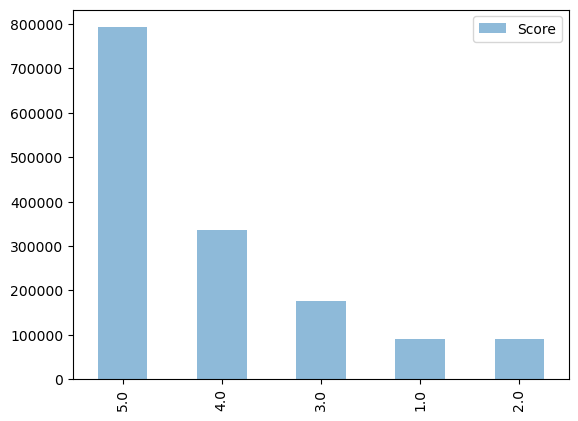


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [ ]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    #feature that sees if number are mentioned in the review and then use that number as rating
    df['AppearsIn'] = df['Text'].apply(stars_in_text)
    df['AppearsIn'] = df['AppearsIn'].fillna(3)

    df['ButAppearance'] = df['Text'].apply(count_buts)
    df['ButAppearance'] = df['ButAppearance'].fillna(0)

    df['isEmpty'] = df['Text'].apply(is_empty)
    df['isEmpty'] = df['isEmpty'].fillna(0)

    # Extract TF-IDF features
    vectorizer = TfidfVectorizer(max_df=0.05, max_features=1000, ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform(df['Text'].fillna(''))  # Fill NaN values with an empty string
    # Create a DataFrame from the TF-IDF matrix
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    df.reset_index(drop=True, inplace=True)  # Reset index to align
    df = pd.concat([df, tfidf_df], axis=1)

    return df, vectorizer

def stars_in_text(text):
    if isinstance(text, str):
        if "1 star" in text:
            return 1
        elif "2 star" in text:
            return 2
        elif "3 star" in text:
            return 3
        elif "4 star" in text:
            return 4
        elif "5 star" in text:
            return 5
    return 3

def count_buts(text):
    if isinstance(text, str):
        return len(re.findall(r'\bbut\b', text, re.IGNORECASE))
    return 0

def is_empty(text):
    if not isinstance(text, str) or len(text) == 0:
        return 1
    return 0

# Load the feature extracted files if they've already been generated
if exists('./data/X_train2.csv'):
    X_train = pd.read_csv("./data/X_train2.csv")
if exists('./data/X_submission2.csv'):
    X_submission = pd.read_csv("./data/X_submission2.csv")


# # Load the feature extracted files if they've already been generated
# if exists('./data/X_train.csv'):
#     X_train = pd.read_csv("./data/X_train.csv")
# if exists('./data/X_submission.csv'):
#     X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train, vectorizer = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission2.csv", index=False)
    X_train.to_csv("./data/X_train2.csv", index=False)


# UNDER HERE SHOULD TYPICIALLY BE IN DIFFERENT CELL BUT I JUST WANT IT ALL TO RUN
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Define specific features and include TF-IDF features
base_features = ['Helpfulness', 'AppearsIn', 'ButAppearance', 'isEmpty']
tfidf_features = vectorizer.get_feature_names_out().tolist()
selected_features = base_features + tfidf_features

X_train_select = X_train[selected_features]
X_test_select = X_test[selected_features]
X_submission_select = X_submission[selected_features]


# features = ['Helpfulness', 'AppearsIn', 'ButAppearance', 'isEmpty']

# X_train_select = X_train[features]
# X_test_select = X_test[features]
# X_submission_select = X_submission[features]

# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)


# # Save the model and the vectorizer
# save_object(model, './data/model.pkl')
# save_object(vectorizer, './data/tfidf_vectorizer.pkl')

Accuracy on testing set =  0.4625245061076761


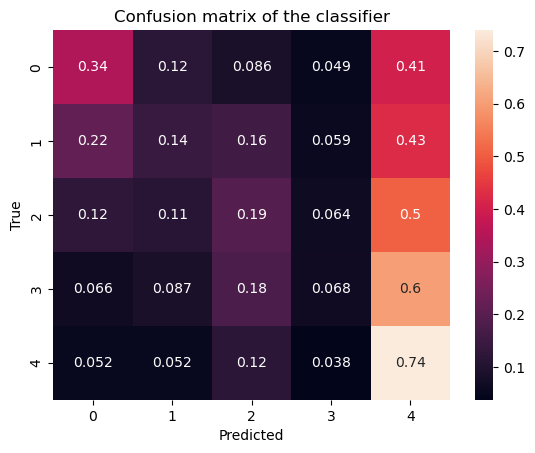

In [7]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()